In [1]:
%reset -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

# Read Training Images Names

Here I am reading training images names for cars and non cars and printing some stats about them.

In [3]:
import glob

def read_training_images_names():
    cars_images_names = glob.glob("data/vehicles/**/*.png", recursive=True)
    non_cars_images_names = glob.glob("data/non-vehicles/**/*.png", recursive=True)
    
    return (cars_images_names, non_cars_images_names)

# Define a function to return some characteristics of the dataset 
def data_look(cars_list, non_cars_list):
    data_dict = {}
    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(cars_list)
    # Define a key in data_dict "n_notcars" and store the number of not car images
    data_dict["n_notcars"] = len(non_cars_list)
    
    #read some test img to get its shape information
    img = mpimg.imread(cars_list[0])
    #store image shape info
    data_dict["image_shape"] = (img.shape[0], img.shape[1], img.shape[2])
    #store image typ info
    data_dict["data_type"] = img.dtype
    
    return data_dict

cars images:  8792
non-cars images:  8968
data_dict:  {'image_shape': (64, 64, 3), 'data_type': dtype('float32'), 'n_notcars': 8968, 'n_cars': 8792}


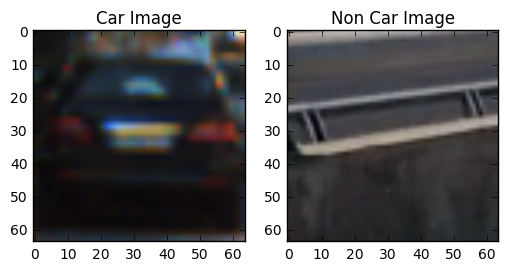

In [4]:
import random

def test_read_data():
    (cars_images_names, non_cars_images_names) = read_training_images_names()
    print("cars images: ", len(cars_images_names))
    print("non-cars images: ", len(non_cars_images_names))
    print("data_dict: ", data_look(cars_images_names, non_cars_images_names))
    
    car_index = random.randint(0, len(cars_images_names))
    non_car_index = random.randint(0, len(non_cars_images_names))
    
    car_img = mpimg.imread(cars_images_names[car_index])
    non_car_img = mpimg.imread(non_cars_images_names[non_car_index])
    
    plt.subplot(121)
    plt.title("Car Image")
    plt.imshow(car_img)
    plt.subplot(122)
    plt.title("Non Car Image")
    plt.imshow(non_car_img)
    
test_read_data()

# Drawing Bounding Boxes

A function will be needed to draw bounding boxes around detected cars. Here I am writing that function to use it later in my code. 

In [5]:
# takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
# make a copy of the image
# draw each bounding box on your image copy using cv2.rectangle()
# return the image copy with boxes drawn
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    img_to_drawn_on = np.copy(img)
    
    for (p1,p2) in bboxes:
        cv2.rectangle(img_to_drawn_on, p1, p2, color, thick)
        
    return img_to_drawn_on

**Testing drawing of bounding boxes on a test image**

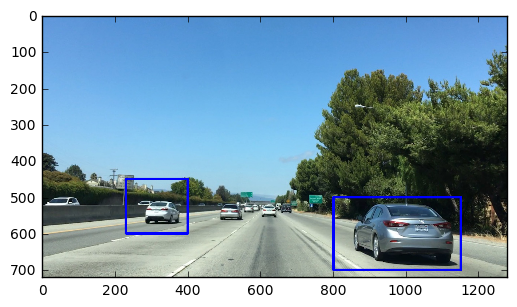

In [6]:
def test_draw_boxes():
    img = mpimg.imread("test_images/bbox-example-image.jpg")
    bboxes = [((230, 600), (400, 450)), ((800, 700), (1150, 500))]
    drawn_img = draw_boxes(img, bboxes)
    plt.imshow(drawn_img)
    
    
test_draw_boxes()

# Color Histogram Features

To train classifier multiple features will be needed to feed them to classifier to learn. Here I am coding function to extract histogram of all color channels combined and concatenated into a single feature vector. As cars have special colors different than that of road color or sorrounding environment like trees so features like these can be very helpful.  

In [7]:
def plot_hist(hist, title=None):
    # Generating bin centers
    bin_edges = hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    plt.figure()
    if (title != None):
        plt.title(title)
    plt.bar(bin_centers, hist[0])

def color_histogram(img, nbins=32, bins_range=(0, 256), visualise=False):
    # Take histograms in channel1, channel2, and channel3
    c1hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    c2hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    c3hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    
    if (visualise):
        plot_hist(c1hist, "Channel-1")
        plot_hist(c2hist, "Channel-2")
        plot_hist(c3hist, "Channel-3")
    
#     bin_edges = c1hist[1]
#     bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((c1hist[0], c2hist[0], c2hist[0]))
    
    return hist_features

**Testing to see histogram is being extracted fine on a test image.**

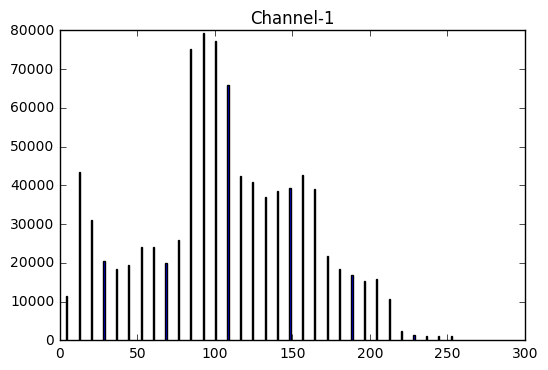

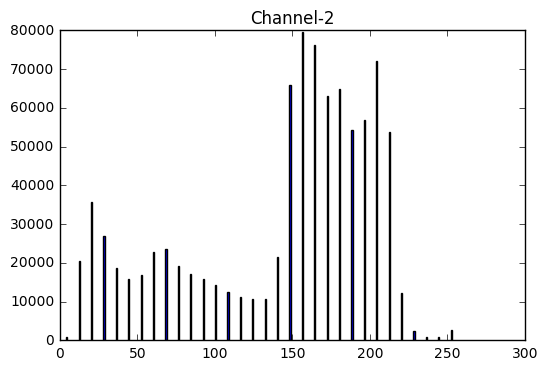

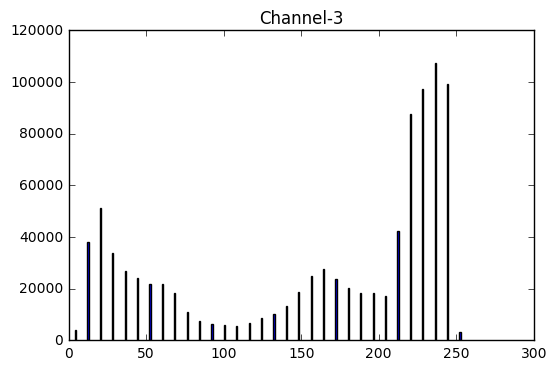

In [8]:
def test_histogram():
    img = mpimg.imread("test_images/bbox-example-image.jpg")
    hist_features = color_histogram(img, visualise=True)
    
test_histogram()

# Spatial Binning 

Feeding spatial features to classifier can be helpful. As images can be of large sizes and converting them as they are to feature vectors can cost memory and performance. So here I am resizing image and then converting it to a feature vector. 

In [9]:
#define color space string to cv2 code conversion
def get_color_space_code(color_space):
    if color_space == 'HSV':
        return cv2.COLOR_RGB2HSV
    elif color_space == 'LUV':
        return cv2.COLOR_RGB2LUV
    elif color_space == 'HLS':
        return cv2.COLOR_RGB2HLS
    elif color_space == 'YUV':
        return cv2.COLOR_RGB2YUV
    elif color_space == 'YCrCb':
        return cv2.COLOR_RGB2YCrCb
    
# A function that takes an image
# and a new image size
# and returns a feature vector
def bin_spatial(img, size=(32, 32)):
    # Return the feature vector
    img_small = cv2.resize(img, size)
    return img_small.ravel()

**Plotting spatial features**

Features length:  (3072,)


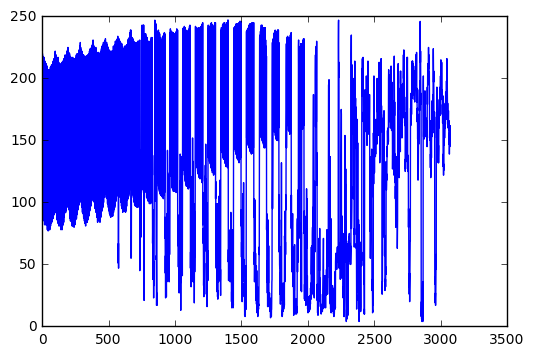

In [10]:
def test_binning():
    img = mpimg.imread("test_images/bbox-example-image.jpg")
    
    binned_features = bin_spatial(img)
    print("Features length: ", binned_features.shape)
    plt.plot(binned_features)
    
test_binning()

# HOG Features

Histogram and color features are helpful but similar features can be found for multiple other objects as well. For example an advertisement board on a road can have similar color/histogram features. We need features that catch shape of object as well and also have the ability to handle some minor variations in the shape as cars have different shapes. HOG features catch similar properties and can be helpful so defining a function here to extract HOG features from a given image and given channel (or All channels combined).

In [11]:
from skimage.feature import hog

#A function to return HOG features and visualization from a single channel image
def get_hog_features(gray_img, 
                     orientations, 
                     pixs_per_cell, 
                     cells_per_block, 
                     visualise=False, 
                     feature_vector=True):
    if(visualise):
        features, hog_image = hog(gray_img, orientations=orientations,
                                  pixels_per_cell=(pixs_per_cell, pixs_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block), 
                                  visualise=visualise, 
                                  feature_vector=feature_vector)
        return features, hog_image
    else:
        features = hog(gray_img, orientations=orientations, pixels_per_cell=(pixs_per_cell, pixs_per_cell),
                                 cells_per_block=(cells_per_block, cells_per_block), 
                                  visualise=visualise, 
                                  feature_vector=feature_vector)
        
        return features
    
#function to extract hog features from multi-channel image
def get_hog_features_channeled(img, 
                               hog_channel=0,
                               orientations=9, 
                               pixs_per_cell=8, 
                               cells_per_block=2):
    hog_features = []
    if (hog_channel == 'ALL'):
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(img[:, :, channel], 
                                                 orientations,
                                                 pixs_per_cell,
                                                 cells_per_block))
            
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(img[:, :, hog_channel],
                                        orientations,
                                        pixs_per_cell,
                                        cells_per_block)
        
    return hog_features

**Testing HOG features on a test image to see if they are being extracted fine.**

features count:  (2592,)


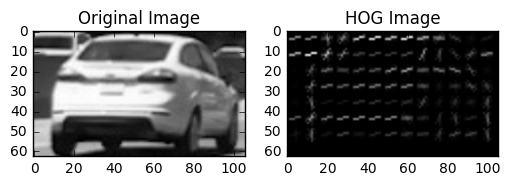

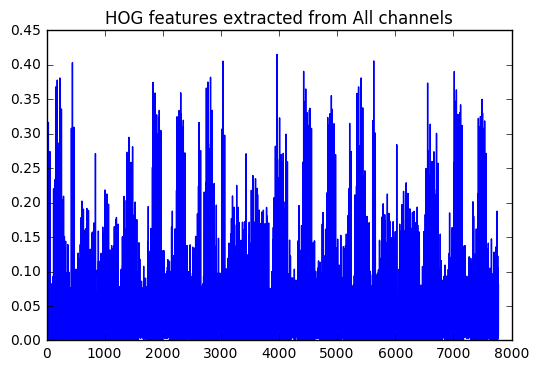

In [12]:
def test_hog():
    img = mpimg.imread("test_images/cutout1.jpg")
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray_img, 
                                           orientations=9, 
                                           pixs_per_cell=8, 
                                           cells_per_block=2, 
                                           visualise=True)
    
    print('features count: ', features.shape)
    plt.subplot(121)
    plt.title("Original Image")
    plt.imshow(gray_img, cmap='gray')
    
    plt.subplot(122)
    plt.title("HOG Image")
    plt.imshow(hog_image, cmap='gray')
    
    hog_features_multi_channel = get_hog_features_channeled(img, hog_channel='ALL')
    plt.figure()
    plt.title("HOG features extracted from All channels")
    plt.plot(hog_features_multi_channel)
    
test_hog()

# Extract All features Combined

Writing a function to extract either all 3 feature vectors (color histogram, spatial, HOG) combined or selected based on flags passed as parameter, from a single image so that I can later experiment with each one of them to see what works best for this project. 

In [13]:
#a function to extract features from a single image window
def extract_single_img_features(image, 
                                cspace='RGB', 
                                spatial_size=(32, 32),
                                hist_bins=32, 
                                orient=9, 
                                pix_per_cell=8, 
                                cell_per_block=2, 
                                hog_channel=0,
                                spatial=True, 
                                histogram=True, 
                                hog_feature=True):
    #Define an empty list to receive features
    img_features = []
    #Apply color conversion if other than 'RGB'
    if(cspace != 'RGB'):
        image = cv2.cvtColor(image, get_color_space_code(cspace))
            
    #Compute spatial features if flag is set
    if(spatial):
        spatial_features = bin_spatial(image, size=spatial_size)
        img_features.append(spatial_features)
    
    #Compute histogram features if flag is set
    if(histogram):
        hist_features = color_histogram(image, nbins=hist_bins)
        img_features.append(hist_features)
        
    #Compute hog features if flag is set
    if(hog_feature):
        hog_features = get_hog_features_channeled(image, orientations=orient,
                                                 pixs_per_cell=pix_per_cell,
                                                 cells_per_block=cell_per_block, hog_channel=hog_channel)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

**Testing feature extraction from a single image.**

Features length:  5760


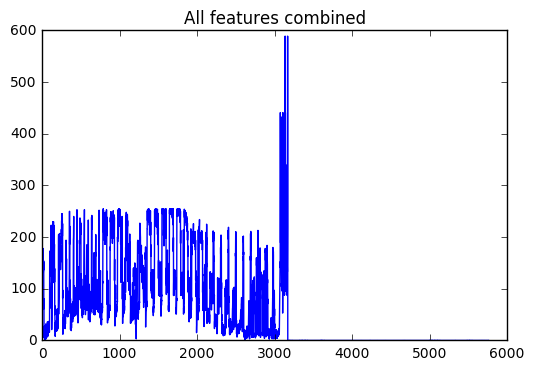

In [14]:
def test_single_img_feature_extraction():
    img = mpimg.imread("test_images/cutout1.jpg")
    all_features = extract_single_img_features(img)
    
    print("Features length: ", len(all_features))
    plt.title("All features combined")
    plt.plot(all_features)
    
test_single_img_feature_extraction()

### Extracting Features from Multiple Images

For training we need to extract features from multiple images so defining a helper function for later convinience.

In [15]:
def extract_multi_img_features(imgs, 
                             cspace='RGB', 
                             spatial_size=(32, 32), 
                             hist_bins=32, 
                             orient=9, 
                             pix_per_cell=8, 
                             cell_per_block=2, 
                             hog_channel=0,
                             spatial=True, 
                             histogram=True, 
                             hog_feature=True,
                             scale_data=False):
    features = []
    for iname in imgs:
        image = mpimg.imread(iname)
        #in case images were png then scaling them to 0-255
        #range as mpimg by default scales them to 0-1 range
        if (scale_data):
            image = image.astype(np.float32) * 255
#             print(np.max(image))
#             print(np.min(image))
            
        image_features = extract_single_img_features(image, 
                                                    cspace, 
                                                    spatial_size,
                                                    hist_bins, 
                                                    orient, 
                                                    pix_per_cell, 
                                                    cell_per_block, 
                                                    hog_channel, 
                                                    spatial, 
                                                    histogram, 
                                                    hog_feature)
        features.append(image_features)
        
    return features

**Testing feature extraction of multipte images.**

Multiple images features:  (8792, 4932)


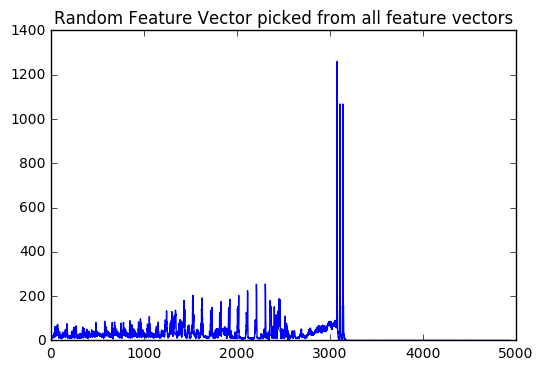

In [16]:
import random

def test_multi_img_feature_extraction():
    cars_images_name, non_car_images_names = read_training_images_names()
    cars_features = extract_multi_img_features(cars_images_name, scale_data=True)
    
    print("Multiple images features: ", np.array(cars_features).shape)
    random_index = random.randint(0, len(cars_images_name))
    random_feature_vector = cars_features[random_index]
    
    plt.title("Random Feature Vector picked from all feature vectors")
    plt.plot(random_feature_vector)
    
test_multi_img_feature_extraction()

# Normalization

Looking at the image above it is clear that some features are dominating over other features and we want all features to be considered equally so that decision making is clear and not biased. So a normalization is needed. I am using `StandardScaler` normalizer from from `sklearn.preprocessing` package which normalises data to zero mean and unit variance. 

In [17]:
from sklearn.preprocessing import StandardScaler

def fit_scaler(row_wise_features):
    scaler = StandardScaler().fit(row_wise_features)
    scaled_x = scaler.transform(row_wise_features)
    
    return scaled_x, scaler

def stack_features_for_scaler_fit(feature_list):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    x = np.vstack(feature_list).astype(np.float64)
    return x

**Testing normalization on a test image features to see if it is working fine.**

Multiple images features:  (17760, 4932)


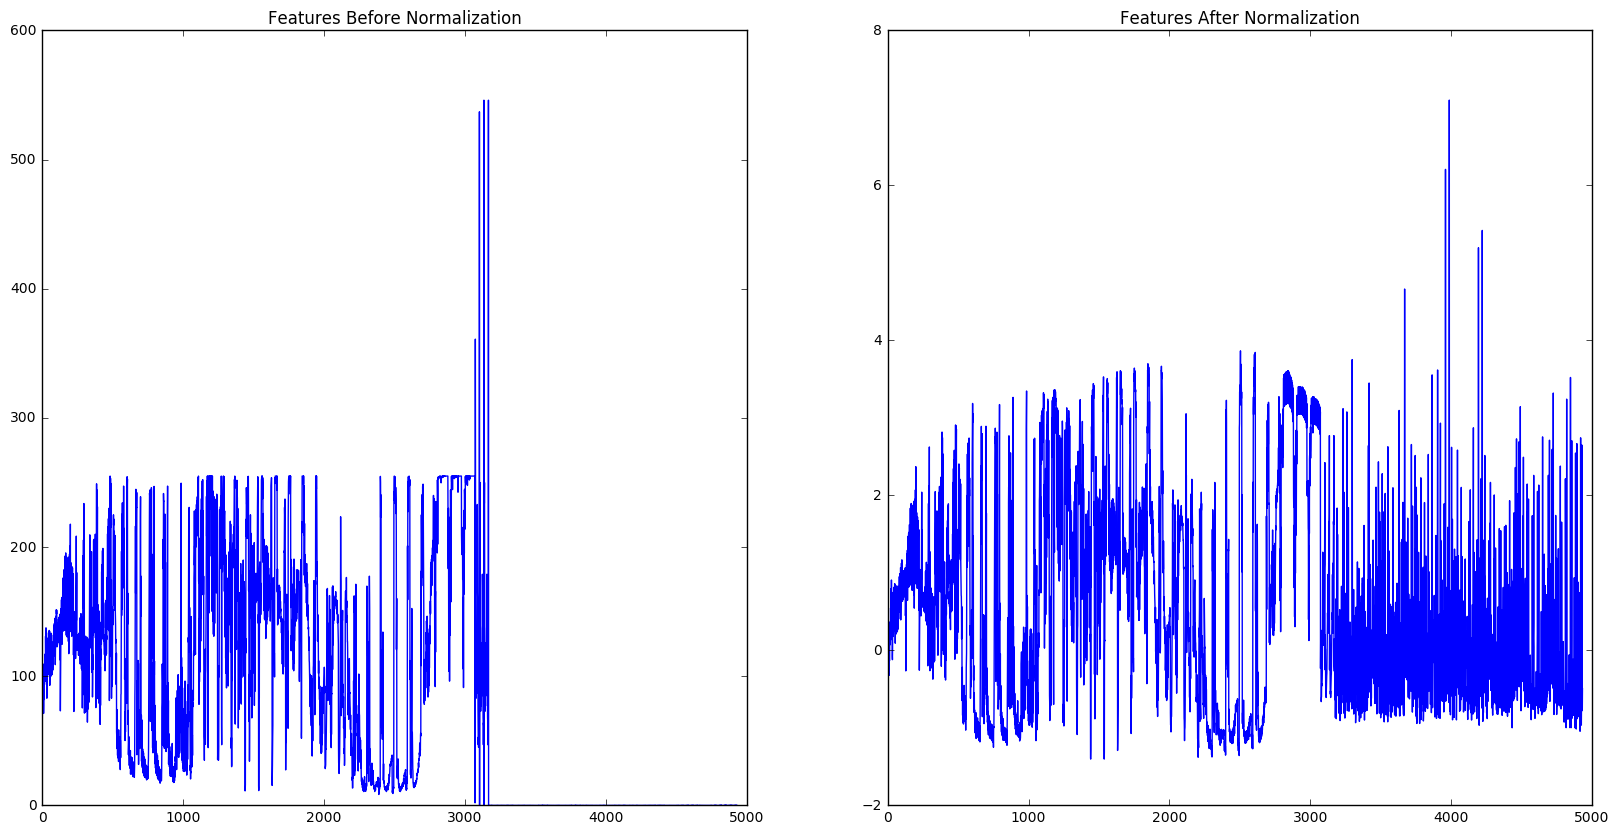

In [18]:
def test_normalization():
    cars_images_names, non_cars_images_names = read_training_images_names()
    cars_features = extract_multi_img_features(cars_images_names, scale_data=True)
    non_cars_features = extract_multi_img_features(non_cars_images_names, scale_data=True)
    
    feature_list = np.vstack((cars_features, non_cars_features)).astype(np.float64)
    
    print("Multiple images features: ", np.array(feature_list).shape)
    random_index = random.randint(0, len(cars_images_names))
    random_feature_vector = feature_list[random_index]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title("Features Before Normalization")
    ax1.plot(random_feature_vector)
    
    normalized_features, scaler = fit_scaler(feature_list)
    normalized_feature_vector = normalized_features[random_index]
    ax2.set_title("Features After Normalization")
    ax2.plot(normalized_feature_vector)
    
test_normalization()

# Prepare Data

Here I am preparing my whole data to be fed to classifier. 
- Reading car and non car images names
- Extracting Features from both types' images
- Normalizing those features to zero mean and unit variance using `StandardScaler`
- Define corresponding labels, 1 for car, 0 for non-car
- Splitting data into training and testing (10%). 

**Follow flags shows you the color space, features, color channels and other values I have used to extract features and train my model.**

In [297]:
#global flags 
cspace1="RGB"  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size1=(32, 32)
hist_bins1=32
orient1=9
pix_per_cell1=8
cell_per_block1=2 
hog_channel1='ALL'
spatial1=False
histogram1=False
hog1=True

In [298]:
from sklearn.model_selection import train_test_split

def read_and_prepare_data():
    #read images names
    cars_images_names, non_cars_images_names = read_training_images_names()
    
    #read images and also scale them. Then
    #extract spatial, histogram and/or hog features
    cars_features = extract_multi_img_features(cars_images_names, 
                                               cspace=cspace1, 
                                               spatial_size=spatial_size1, 
                                               hist_bins=hist_bins1,
                                               orient=orient1,
                                               pix_per_cell=pix_per_cell1, 
                                               cell_per_block=cell_per_block1, 
                                               hog_channel=hog_channel1, 
                                               spatial=spatial1,
                                               histogram=histogram1, 
                                               hog_feature=hog1)
    non_cars_features = extract_multi_img_features(non_cars_images_names,
                                                   cspace=cspace1, 
                                                   spatial_size=spatial_size1, 
                                                   hist_bins=hist_bins1,
                                                   orient=orient1,
                                                   pix_per_cell=pix_per_cell1, 
                                                   cell_per_block=cell_per_block1, 
                                                   hog_channel=hog_channel1, 
                                                   spatial=spatial1,
                                                   histogram=histogram1, 
                                                   hog_feature=hog1)

    #normalize features 
    X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
    X_scaled, scaler = fit_scaler(X)

    #define labels: 1 for car, 0 for non-car
    y = np.hstack((np.ones(len(cars_features)), np.zeros(len(non_cars_features))))
    
    #divide data into train and test data
    #note: this function also shuffles the data. I am shuffling it
    #with a random state
    rand_state = random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=rand_state)
    
    #return ready to use data
    return X_train, X_test, y_train, y_test, scaler

In [299]:
X_train, X_test, y_train, y_test, scaler = read_and_prepare_data()

**Printing some stats about training data**

In [300]:
#print some stats
print("Train samples: ", len(X_train))
print("Feature Vector Length: ", len(X_train[0]))
print("Test samples: ", len(X_test))

Train samples:  15984
Feature Vector Length:  5292
Test samples:  1776


# Training Classifier

Here I am training a linear SVM classifier with default values.

In [301]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [302]:
#test accuracy on test set
print('Test accuracy of SVC: ', clf.score(X_test, y_test))

Test accuracy of SVC:  0.975788288288


# Classify 

## Slide Window

To detect on vehicles on a test image we need to slide a window over it multiple times with different scales as there can be multiple vehicles on the road, some far (small size) some near (large size). Here I am defining functions for sliding a window over image. 

In [25]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                window_xy=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if(x_start_stop[0] == None):
        x_start_stop[0] = 0 
    if(x_start_stop[1] == None):
        x_start_stop[1] = img.shape[1]
        
    if(y_start_stop[0] == None):
        y_start_stop[0] = 0 
    if(y_start_stop[1] == None):
        y_start_stop[1] = img.shape[0]
        
#     print("x_start_stop": x_start_stop)
    # Compute the span of the region to be searched    
    W = x_start_stop[1] - x_start_stop[0]
    H = y_start_stop[1] - y_start_stop[0]
#     print("Width, Height: ", W, H)
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = int(window_xy[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = int(window_xy[1] * (1 - xy_overlap[1]))
#     print("Sx, Sy :", nx_pix_per_step, ny_pix_per_step)
    
    # Compute the number of windows in x/y
    if(xy_overlap[0] == 0.0):
        nwindows_x = int(W / (nx_pix_per_step))
    else:
        nwindows_x = int(W / (nx_pix_per_step)) - 1
        
    if(xy_overlap[1] == 0):
        nwindows_y = int(H / (ny_pix_per_step))
    else:
        nwindows_y = int(H / (ny_pix_per_step)) - 1
        
#     print("nwindows_x, nwindows_y: ", nwindows_x, nwindows_y)
    #print("Total windows: ", (nwindows_x * nwindows_y))
    # Initialize a list to append window positions to
    window_list = []
    
    for wy in range(nwindows_y):
        for wx in range(nwindows_x):
            window_startx = x_start_stop[0] + (wx * nx_pix_per_step) #x_start + steps window has already taken
            window_stopx = window_startx + window_xy[0]
            window_starty = y_start_stop[0] + (wy * ny_pix_per_step) #y_start + steps window has already taken
            window_stopy = window_starty + window_xy[1]
            
            window = ((window_startx, window_starty), (window_stopx, window_stopy))
            window_list.append(window)
            
    return window_list

Total windows:  190


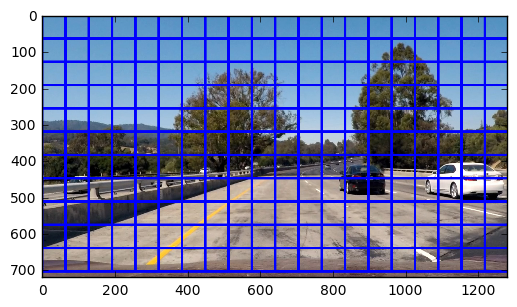

In [26]:
#1280x960 => 1131 total windows with 0.5 overlap
def test_slide_window():
    img = mpimg.imread('test_images/test1.jpg')
    window_list = slide_window(img,
                   window_xy=(128, 128))
    
    print("Total windows: ", len(window_list))
    drawn_img = draw_boxes(img, window_list)
    
    plt.imshow(drawn_img)
    
test_slide_window()

## Optimizing Slide Window

Sliding windows blindly on image can be highly inefficient and slow. We know that cars are going to be in lower part of image and we also know that certain window sizes will find cars only in a certain space of image. Here I have defined windows specifically optimized for finding vehicles.

In total I am using 4 windows restricted in certain image areas:
- window1: 64x64 with 50% overlapping in X direction and 0% overlapping in Y direction
- window2: 100x100 with 75% overlapping in X direction and 75% overlapping in Y direction
- window3: 160x160 with 50% overlapping in X direction and 0% overlapping in Y direction
- window4: 250x250 with 50% overlapping in X direction and 0% overlapping in Y direction

All of these windows were finalized by drawing them on different test images and optimizing each window size and area in which it should scale by looking at which window can detect which cars and where exactly slidding it will be helpful. 

In [701]:
def plot2_figs(img1, img2, title1=None, title2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    if (img1 != None):
        ax1.imshow(img1)
    if (title1 != None):
        ax1.set_title(title1)
        
    if (img2 != None):
        ax2.imshow(img2)
    if (title2 != None):
        ax2.set_title(title2)
    plt.show()

def slide_window_optimized(img, visualise=False):
    
    windows1 = slide_window(img, 
                            y_start_stop=[(img.shape[0]//2 + 40), (img.shape[0]//2 + 150)], 
                            x_start_stop=[(img.shape[1]//2 - 100), (img.shape[1] - 200)],
                            window_xy=(64, 64), xy_overlap=(0.50, 0))
    
    windows2 = slide_window(img, 
                            y_start_stop=[(img.shape[0]//2 + 40), (img.shape[0]//2 + 150)], 
                            x_start_stop=[(img.shape[1]//2 - 100), (img.shape[1])],
                            window_xy=(100, 100), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(img, 
                            y_start_stop=[(img.shape[0]//2), (img.shape[0]//2 + 170)], 
                            x_start_stop=[(img.shape[1]//2 - 170), None],
                            window_xy=(160, 160), xy_overlap=(0.50, 0))
    
    windows4 = slide_window(img, 
                            y_start_stop=[(img.shape[0]//2), (img.shape[0]//2 + 260)], 
                            x_start_stop=[260, None],
                            window_xy=(250, 250), xy_overlap=(0.50, 0))
    
#     windows5 = slide_window(img, 
#                             y_start_stop=[(img.shape[0]//2), None], 
#                             x_start_stop=[300, None],
#                             window_xy=(320, 320), xy_overlap=(0.50, 0))
    
    
    if (visualise):
        img1 = draw_boxes(img, windows1)
        img2 = draw_boxes(img, windows2)
        plot2_figs(img1, img2, title1="64x64 window", title2="100x100 window")
        
        img3 = draw_boxes(img, windows3)
        img4 = draw_boxes(img, windows4)
        plot2_figs(img3, img4, title1="160x160 window", title2="250x250 window")
        
#         img5 = draw_boxes(img, windows5)
#         plot2_figs(img5, None, title1="320x320", title2=None)
        

    windows = (windows1 + windows2 + windows3 + windows4)
    
    return windows

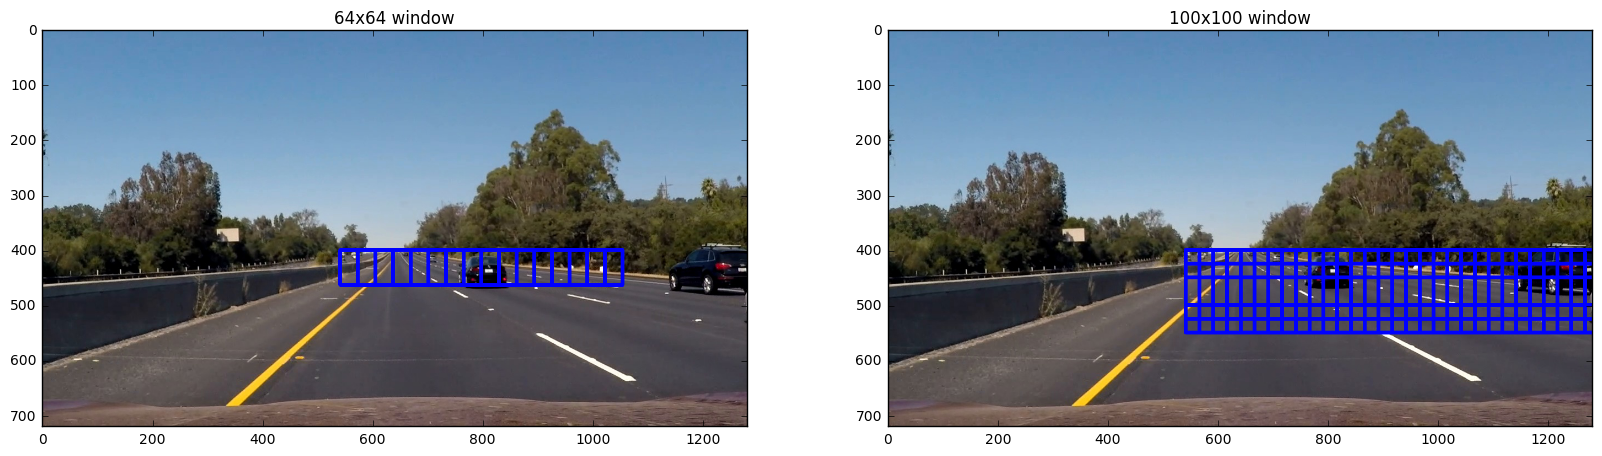

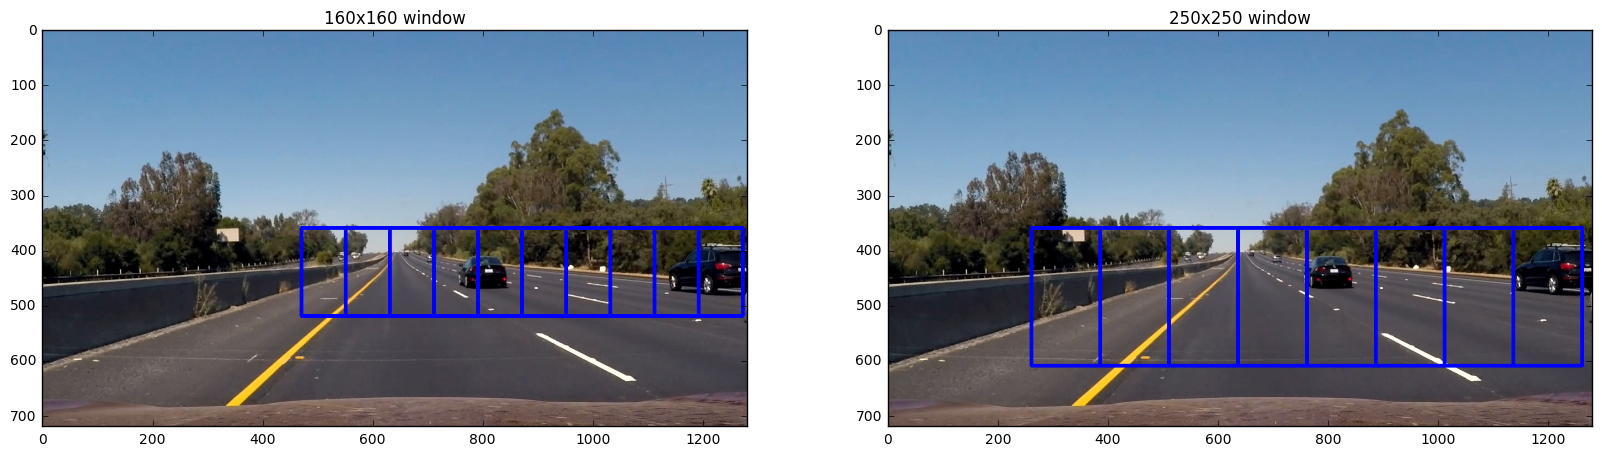

In [700]:
def test_slide_window_optimized():
#     img = mpimg.imread('test_images/test4.jpg')
#     img = mpimg.imread('test_images/mine/707.jpg')
    img = mpimg.imread('test_images/mine/1261.jpg')
    slide_window_optimized(img, visualise=True)
    
test_slide_window_optimized()

# Search All Windows For Possible Hot Windows

Given a list of possible windows we need to slide over image and classify, this function will go through each of them
- Extract window from given test image
- Resize it to (64, 64) which is the size of our training images
- Extract features for that image
- Scale those features using scaler passed, which is the same scaler that we used to scale training data.
- Pass these features to classifier for prediction
- If prediction == 1 then add them to hot windows. 

In [281]:
#a function to pass an image 
# and the list of windows to be searched
def search_windows(img, windows, clf, scaler, 
                   cspace='RGB', 
                   spatial_size=(32, 32),
                   hist_bins=32, 
                   orient=9, 
                   pix_per_cell=8, 
                   cell_per_block=2, 
                   hog_channel=0,
                   spatial=True, 
                   histogram=True, 
                   hog_feature=True):
    #define list to receive positive detected windows
    hot_windows = []
    for window in windows:
        x_start = window[0][0]
        x_end = window[1][0]
        y_start = window[0][1]
        y_end = window[1][1]
        
        img_window = cv2.resize(img[y_start:y_end, x_start:x_end], (64, 64))
        img_features = extract_single_img_features(img_window, 
                                                  cspace, 
                                                  spatial_size,
                                                  hist_bins, 
                                                  orient, 
                                                  pix_per_cell, 
                                                  cell_per_block, 
                                                  hog_channel, 
                                                  spatial, 
                                                  histogram, 
                                                  hog_feature)
        
        #Scale extracted features to be fed to classifier
        scaled_features = scaler.transform(np.array(img_features).reshape(1, -1))
        #Predict using your classifier
        prediction = clf.predict(scaled_features)
        if (prediction == 1):
            hot_windows.append(window)
            
    
    return hot_windows

def search_windows_default(img, windows, clf, scaler):
    return search_windows(img, windows, clf, scaler,
                         spatial_size=spatial_size1, 
                         hist_bins=hist_bins1,
                         orient=orient1,
                         pix_per_cell=pix_per_cell1,
                         cell_per_block=cell_per_block1,
                         hog_channel=hog_channel1,
                         spatial=spatial1,
                         histogram=histogram1,
                         hog_feature=hog1)

# Testing on Test Images

Initially I was using color histogram, spatial and HOG features combined. I was getting a lot of false positives. I tried multiple color spaces but not much improvement. Then using histogram and HOG features combined improved results. Then using only HOG features gave similar vehicle detection results but improved more noise so I switched to HOG only features. After that I tried different color spaces, orientations, pixels per cell etc. to improve my results. This is finally where I got. 

Image name:  test_images/test1.jpg


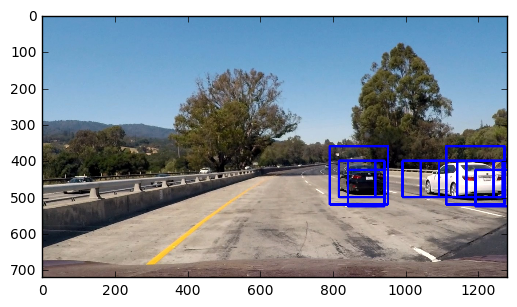

Image name:  test_images/test2.jpg


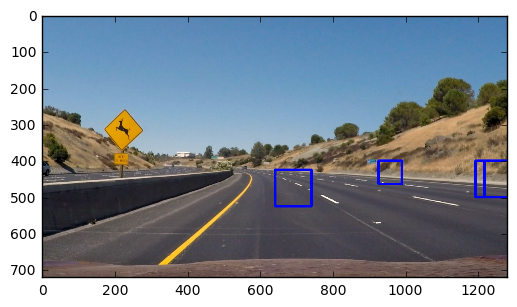

Image name:  test_images/test3.jpg


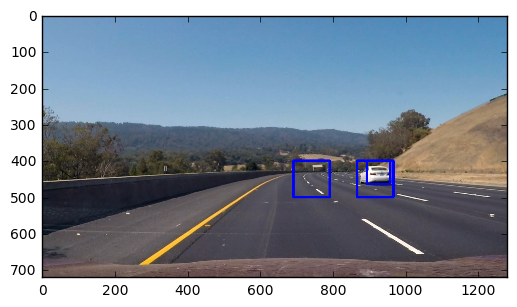

Image name:  test_images/test4.jpg


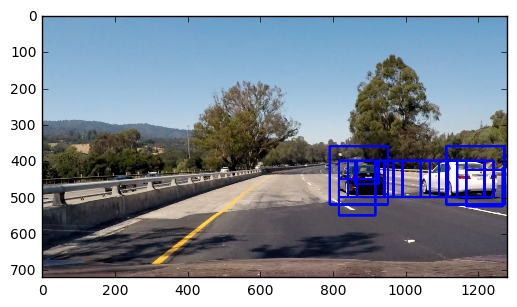

Image name:  test_images/test5.jpg


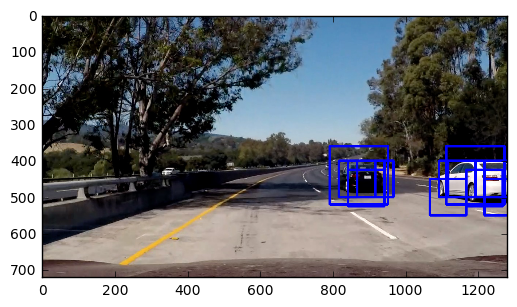

Image name:  test_images/test6.jpg


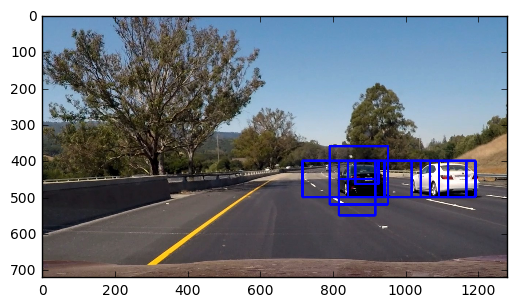

In [707]:
import glob

def test_on_img(img):
    windows = slide_window_optimized(img)
    hot_windows = search_windows_default(img, windows, clf, scaler)
    
    drawn_img = draw_boxes(img, hot_windows)
    plt.figure()
    plt.imshow(drawn_img)
    plt.show()


def test_search_window():
    inames = glob.glob("test_images/test*.jpg")
#     inames.extend(glob.glob("test_images/mine/*.jpg"))
#     inames = np.concatenate(inames)
    for iname in inames:
        print("Image name: ", iname)
        img = mpimg.imread(iname)
        test_on_img(img)
    
test_search_window()

# Remove False Positives

Here I am using heatmap to sum up all the detections and overlapping windows and then I apply a test threshold to combine multiple windows and remove false positives. 

**Note:** The threshold actually used for this project is different and you will see it below in the section where I define class for Heatmap for applying it on a video. 

In [112]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for bbox in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    
    # Zero out pixels below the threshold
    return heatmap
    
def get_labeled_bboxes(image, labels):
    labeled_boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        labeled_boxes.append(bbox)
        # Draw the box on the image
#         cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

    return labeled_boxes
#     return image

**Testing heatmap to see if it works**

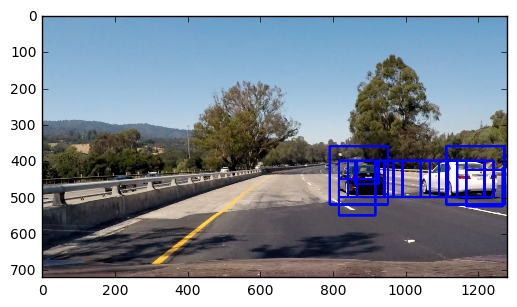

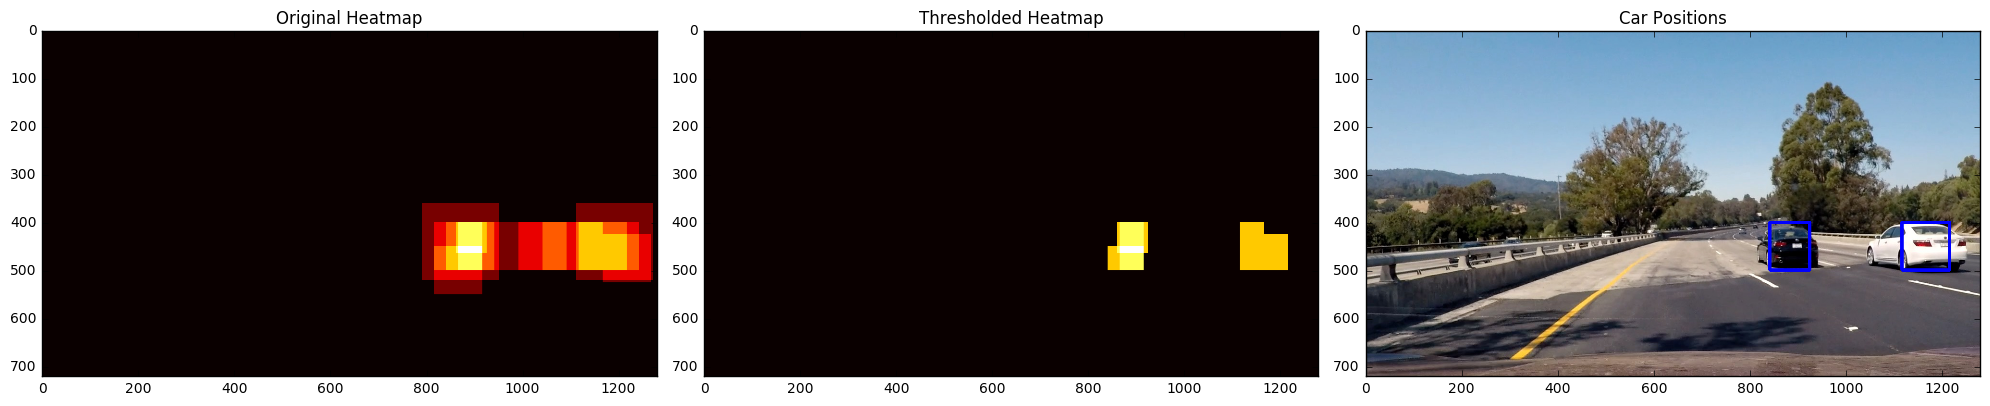

In [710]:
def test_heatmap(img):
#     img = mpimg.imread('test_images/test6.jpg')
    windows = slide_window_optimized(img)
    hot_windows = search_windows_default(img, windows, clf, scaler)
   
    drawn_img = draw_boxes(np.copy(img), hot_windows)
    plt.figure()
    plt.imshow(drawn_img)
    
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    #add heat to map based on detections
    add_heat(heatmap, hot_windows)
    #make a copy
    heatmap_copy = np.copy(heatmap)
    #apply threshold to removed false positives
    apply_threshold(heatmap, 3)
    #limit the pixel values to 0-255 range
    heatmap = np.clip(heatmap, 0, 255)
    
    labels = label(heatmap)
    boxes = get_labeled_bboxes(np.copy(img), labels)
    labeled_image = draw_boxes(img, boxes)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title("Original Heatmap")
    ax1.imshow(heatmap_copy, cmap='hot')
    ax2.set_title("Thresholded Heatmap")
    ax2.imshow(heatmap, cmap='hot')
    ax3.set_title("Car Positions")
    ax3.imshow(labeled_image)
    f.tight_layout()
    
def test_heatmap_on_test_images():
    img = mpimg.imread("test_images/test4.jpg")
    test_heatmap(img)
#     inames = glob.glob("test_images/test*.jpg")
#     for iname in inames:
#         image = mpimg.imread(iname)
#         test_heatmap(image)
    
test_heatmap_on_test_images()

# Using Heatmap on a Video

Here I am actually applying heatmap on test and project videos. Below is the `HeatMap` class I used to apply heatmap on multiple frames and then threshold them. I am also applying an averaging on HeatMap to get smooth bounderis. Following are the important values used:

- Frames for heatmap: 10
- Threshold: 20
- Smoothing/Averaging of Heatmap on a 65x65 window. 

In case I don't find bounding boxes after thresholding heatmap then I draw the bounding boxes obtained from previous heatmap thresholding as even after 10 frames cars are still going to be close to the previous positions.

In [688]:
import cv2

class HeatMap():
    def __init__(self):
        #dfd
        self.heat = None
        self.frames_count = 0
        self.THRESHOLD_FRAMES_COUNT = 10
        self.THRESHOLD_HEAT = 20
        self.prev_boxes = []
        self.verbose = False
        
        self.all_heatmaps = []
        self.N = 2
        
    def add_heatmap(self, heatmap):
        self.all_heatmaps.append(heatmap)
        if (len(self.all_heatmaps) > self.N):
            self.all_heatmaps = self.all_heatmaps[-self.N:]

    def avg_heatmap(self):
        n_heatmaps = self.all_heatmaps[-self.N:]        
        sum1 = np.zeros_like(n_heatmaps[0])
        for h in n_heatmaps:
            sum1 += np.array(h)
            
        avg = sum1 / len(n_heatmaps)
        return avg
    
    def temp_avg(self, heat):
        if(len(self.all_heatmaps) == 0):
            return heat
        
        n_heatmaps = self.all_heatmaps[-self.N:]
        
        sum1 = np.zeros_like(n_heatmaps[0])
        for h in n_heatmaps:
            sum1 += np.array(h)
            
        sum1 += np.array(heat)
        avg = sum1 / (len(n_heatmaps) + 1)
        return avg
        
    def init_heatmap(self, img):
        self.heat = np.zeros_like(img[:, :, 0]).astype(np.float)
        self.frames_count = 0
        
    def add_heat(self, boxes):
        self.heat = add_heat(self.heat, boxes)
        self.frames_count += 1
        
        if (self.verbose):
            print('frames count: ', self.frames_count)
    
    def is_ready(self):
        return (self.frames_count == self.THRESHOLD_FRAMES_COUNT)
    
    def draw_labeled_boxes(self, img):
        #show heatmap before thresholding to visualize noise/False positives
        if (self.verbose):
            print('applying threshold of : ', self.THRESHOLD_HEAT)
            plt.figure()
            plt.title("Before Threshold")
            plt.imshow(np.copy(self.heat), cmap='hot')
            
        self.heat = cv2.blur(self.heat, (65, 65))
#         self.heat = cv2.medianBlur(self.heat.astype(np.uint8), 9)
#         self.heat = cv2.GaussianBlur(self.heat, (9,9), 0)
    
#         if (self.verbose):
#             plt.figure()
#             plt.title("Before Threshold, Blurred Img")
#             plt.imshow(np.copy(self.heat), cmap='hot')
        
        #limit the pixel values to 0-255 range
        self.heat = np.clip(self.heat, 0, 255)
        self.heat[(self.heat <= self.THRESHOLD_HEAT)] = 0
        
        #show thresholded heatmap for visualization
        if (self.verbose):
            plt.figure()
            plt.title("After threshold")
            plt.imshow(np.copy(self.heat), cmap='hot')
            
#         self.add_heatmap(self.heat)
#         avg_heat = self.avg_heatmap()
        avg_heat = self.heat
        
#         if (self.verbose):
#             plt.figure()
#             plt.title("Avg Heatmap")
#             plt.imshow(np.copy(avg_heat), cmap='hot')
        
        labels = label(avg_heat)
        boxes = get_labeled_bboxes(img, labels)
        
        if (len(boxes) == 0):
            draw_boxes(img, self.prev_boxes)
        
        labeled_image = draw_boxes(img, boxes)
        
        #show drawn img for verbose
        if (self.verbose):
            plt.figure()
            plt.imshow(np.copy(labeled_image))
        
        #reset heatmap to start from scratch again
        self.init_heatmap(img)
        if (len(boxes) > 0):
            self.prev_boxes = boxes
        
        return labeled_image
    
    def draw_prev_boxes(self, img):
        labeled_image = draw_boxes(img, self.prev_boxes)
        return labeled_image
    
    def draw_boxes(self, img):
        if (self.is_ready()):
            img = self.draw_labeled_boxes(img)
        elif(self.prev_boxes != None):
            img = self.draw_prev_boxes(img)
            
        return img
        
        

In [473]:
hm = HeatMap()
def process_img_optimized(img):
    windows = slide_window_optimized(img)
    hot_windows = search_windows_default(img, windows, clf, scaler)
    
    if(hm.heat == None):
        hm.init_heatmap(img)
        
    hm.add_heat(hot_windows)
    img = hm.draw_boxes(img)
    
    return img

In [480]:
hm = None
hm = HeatMap()
hm.verbose = True
def test_process_img_optimized():
    img1 = mpimg.imread('test_images/test4.jpg')
    img2 = mpimg.imread('test_images/test5.jpg')
    img3 = mpimg.imread('test_images/test6.jpg')
    img4 = mpimg.imread('test_images/test1.jpg')
    drawn_img = process_img_optimized(img1)
    drawn_img = process_img_optimized(img2)
    drawn_img = process_img_optimized(img3)
    
test_process_img_optimized()

frames count:  1
frames count:  2
frames count:  3


## Run on Test Video

Runnig on test video provided by Udacity. I plotting each heatmap and its thresholed version to see analyse it and optimize my window sizes and my algorithm. 

frames count:  1
[MoviePy] >>>> Building video test_video_detected1.mp4
[MoviePy] Writing video test_video_detected1.mp4



  3%|▎         | 1/39 [00:00<00:14,  2.56it/s]

frames count:  2



  5%|▌         | 2/39 [00:00<00:14,  2.60it/s]

frames count:  3



  8%|▊         | 3/39 [00:01<00:13,  2.62it/s]

frames count:  4



 10%|█         | 4/39 [00:01<00:13,  2.65it/s]

frames count:  5



 13%|█▎        | 5/39 [00:01<00:12,  2.67it/s]

frames count:  6



 15%|█▌        | 6/39 [00:02<00:12,  2.69it/s]

frames count:  7



 18%|█▊        | 7/39 [00:02<00:11,  2.68it/s]

frames count:  8



 21%|██        | 8/39 [00:02<00:11,  2.66it/s]

frames count:  9


frames count:  10
applying threshold of :  20



 26%|██▌       | 10/39 [00:03<00:12,  2.36it/s]

frames count:  1



 28%|██▊       | 11/39 [00:04<00:11,  2.46it/s]

frames count:  2



 31%|███       | 12/39 [00:04<00:10,  2.50it/s]

frames count:  3



 33%|███▎      | 13/39 [00:05<00:10,  2.55it/s]

frames count:  4



 36%|███▌      | 14/39 [00:05<00:09,  2.61it/s]

frames count:  5



 38%|███▊      | 15/39 [00:05<00:09,  2.64it/s]

frames count:  6



 41%|████      | 16/39 [00:06<00:08,  2.69it/s]

frames count:  7



 44%|████▎     | 17/39 [00:06<00:08,  2.67it/s]

frames count:  8



 46%|████▌     | 18/39 [00:06<00:07,  2.66it/s]

frames count:  9



 49%|████▊     | 19/39 [00:07<00:08,  2.34it/s]

frames count:  10
applying threshold of :  20



 51%|█████▏    | 20/39 [00:07<00:07,  2.44it/s]

frames count:  1



 54%|█████▍    | 21/39 [00:08<00:07,  2.54it/s]

frames count:  2



 56%|█████▋    | 22/39 [00:08<00:06,  2.57it/s]

frames count:  3



 59%|█████▉    | 23/39 [00:08<00:06,  2.63it/s]

frames count:  4



 62%|██████▏   | 24/39 [00:09<00:05,  2.67it/s]

frames count:  5



 64%|██████▍   | 25/39 [00:09<00:05,  2.69it/s]

frames count:  6



 67%|██████▋   | 26/39 [00:10<00:04,  2.70it/s]

frames count:  7



 69%|██████▉   | 27/39 [00:10<00:04,  2.73it/s]

frames count:  8



 72%|███████▏  | 28/39 [00:10<00:03,  2.75it/s]

frames count:  9



 74%|███████▍  | 29/39 [00:11<00:04,  2.42it/s]

frames count:  10
applying threshold of :  20



 77%|███████▋  | 30/39 [00:11<00:03,  2.49it/s]

frames count:  1



 79%|███████▉  | 31/39 [00:12<00:03,  2.53it/s]

frames count:  2



 82%|████████▏ | 32/39 [00:12<00:02,  2.54it/s]

frames count:  3



 85%|████████▍ | 33/39 [00:12<00:02,  2.56it/s]

frames count:  4



 87%|████████▋ | 34/39 [00:13<00:01,  2.58it/s]

frames count:  5



 90%|████████▉ | 35/39 [00:13<00:01,  2.60it/s]

frames count:  6



 92%|█████████▏| 36/39 [00:13<00:01,  2.63it/s]

frames count:  7



 95%|█████████▍| 37/39 [00:14<00:00,  2.60it/s]

frames count:  8



 97%|█████████▋| 38/39 [00:14<00:00,  2.64it/s]

frames count:  9


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_detected1.mp4 

CPU times: user 14.5 s, sys: 221 ms, total: 14.7 s
Wall time: 15.6 s


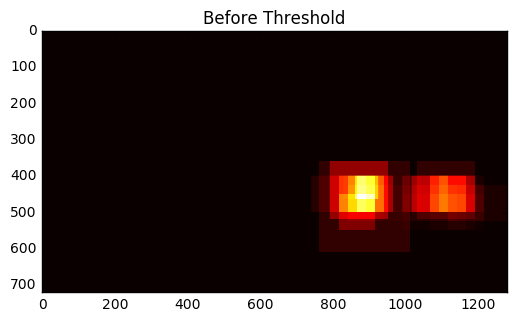

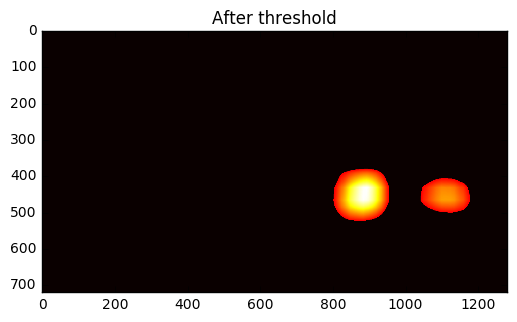

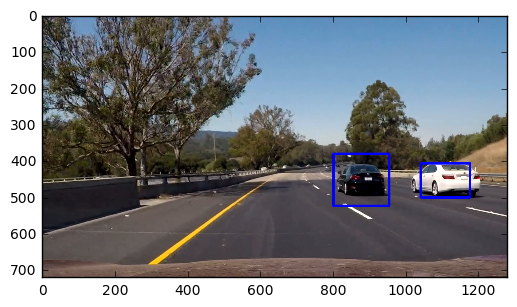

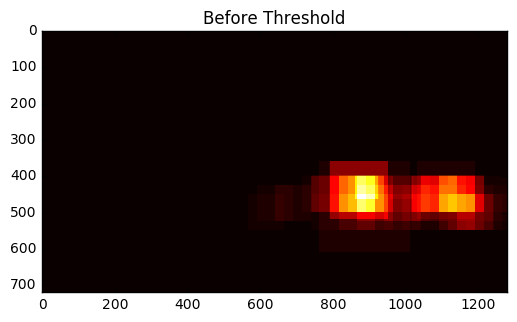

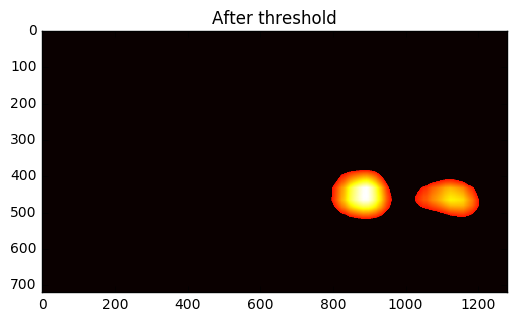

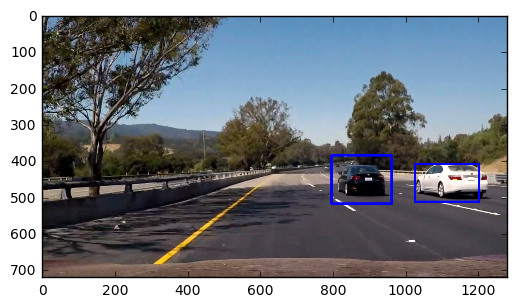

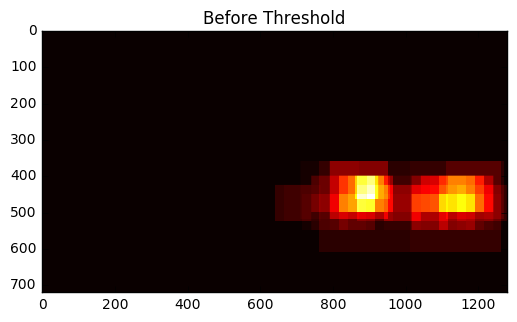

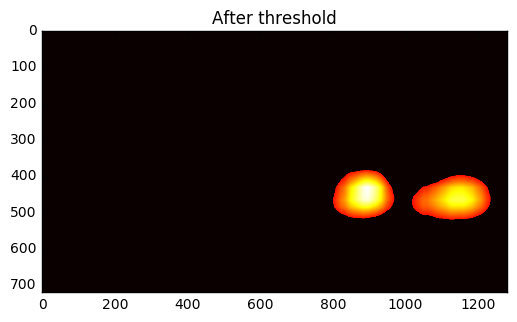

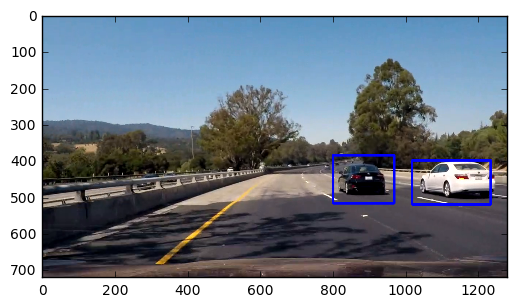

In [703]:
hm = None
hm = HeatMap()
hm.verbose = True
###
output_file_name = "test_video_detected1.mp4"
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(process_img_optimized) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_file_name, audio=False)

In [712]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_detected1.mp4"))

# Run on Project Video

Running on project video provided by Udacity. 

In [706]:
hm = None
hm = HeatMap()
###
output_file_name = "project_video_detected.mp4"
clip1 = VideoFileClip("project_video.mp4")
# output_file_name = "videos/part3_detected.mp4"
# clip1 = VideoFileClip("videos/part3.mp4")
output_clip = clip1.fl_image(process_img_optimized) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_file_name, audio=False)

[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4



100%|█████████▉| 1260/1261 [07:46<00:00,  2.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detected.mp4 

CPU times: user 7min 38s, sys: 6.84 s, total: 7min 45s
Wall time: 7min 47s


In [714]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_detected.mp4"))

# Discussion 

## Issues Faced

- In this project I faced a lot issues on my path to reaching these results. Initially I was using there all 3 features (color histogram, spatial, HOG) and I was getting a lot of false positives. They were simply out of control. I tried different color spaces but no luck. After that I tried only HOG and Histogram, results were better. Later I tried only HOG and there was even less false positives. 

- Then optimizing window scales and image areas where to slide which scale window was tough (at least for me). I have to draw different sized windows over different test images to see what windows fits most of the cars they are supposed to fit. It was a time consuming task and it removed most of the False positives and I believe if they are optimized more even more false positives can be removed and better results can be achieved.

- Lastly, deciding a threshold for heatmap was also problematic as some thresholds did not filter all false postives from heatmaps and some even filtered actual car detections. Finding a balance was difficult. Then after I change even one window scale I have to optimize my threshold again. To see how threshold is affecting my results I drawn all the heatmaps (original heatmap, thresholded heatmap) for test video and saw how thresholding was affecting my results. 

## Algorithm Fail Cases 

There can be many fail cases but these are some of them. 

- Although I spent a lot of time optimizing my windows I still think that they needs to be optimized for this code to work on other videos. For example, (I think, did not test it) running this code on a left lane will not give good results as my windows are too optimized for right lane. 

- I think on areas where there are a lot of buildings/boards very near to edges of roads this code might fail. For that I have optimized my window scales to avoid going out of edges but it still considers at least some. 

- I have noticed that parts where there are shadows or road is not smooth (white parts of road) I get more false positives so I think running this algorithm on roads like these will not give good results.

## Improvements 

- Window scales and image areas where each window scale should slide on can be optimized. 
- Right now in which direction car is moving and how quickly, this information is completely ignored but I think it can be used to estimate cars position in next few frames which can be used to verify/optimize algorithm detections.
- Threshold can be optimized more. 
- I think using HOG features only is not enough, more good features can be feed to classifier to improve it's results. 